In [1]:
import os
import re
import h5py
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

os.environ['CUDA_VISIBLE_DEVICES']='2'

2023-11-09 23:02:40.165057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 23:02:40.823094: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Signal region and sideband region 

In [2]:
def get_info(path):
    # path: run path
    name = os.path.split(path)[1]

    with open(os.path.join(path, f'{name}_tag_1_banner.txt')) as f:
        for line in f.readlines():
                
            #  Integrated weight (pb)  :       0.020257
            match = re.match('#  Integrated weight \(pb\)  : +(\d+\.\d+)', line)
            if match:
                # unit: fb
                cross_section = float(match.group(1)) * 1000
            # #  Number of Events        :       100000
            match = re.match('#  Number of Events        :       (\d+)', line)
            if match:
                # unit: fb
                nevent = int(match.group(1))
    
    return cross_section, nevent

In [3]:
def DeltaR(eta1,phi1, eta2,phi2):
    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

def FourMomentum(pt, eta, phi, m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    return e, px, py, pz

def PtEtaPhiM(px, py, pz, e):
    E, px, py, pz = e, px, py, pz  
    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1./2.*np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(E**2 - px**2 - py**2 - pz**2)

    return pt, eta, phi, m
    
def InvM(e, px, py, pz):
    return np.sqrt(np.sum(e)**2 - np.sum(px)**2 - np.sum(py)**2 - np.sum(pz)**2)

def Mjets(*arg):
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

In [4]:
def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest      

In [5]:
def XHH(m1, m2, m10=120, m20=110):
    # m1: leading Higgs candidate mass
    # m2: sub-leading Higgs candidate mass
    
    return (((m1-m10)/(0.1*m1))**2 + ((m2-m20)/(0.1*m2))**2)**0.5

def min_dR_method(PT, Eta, Phi, Mass):
    # get h-jets pairing
    pairing = []
    for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):

        PT1 = PT[[i1,i2]] 
        Eta1 = Eta[[i1,i2]]
        Phi1 = Phi[[i1,i2]]
        Mass1 = Mass[[i1,i2]]
        
        e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
        PTH1, EtaH1, PhiH1, _ = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

        PT2 = PT[[i3,i4]]
        Eta2 = Eta[[i3,i4]]
        Phi2 = Phi[[i3,i4]]
        Mass2 = Mass[[i3,i4]]

        e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
        PTH2, EtaH2, PhiH2, _ = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))
        
        # sorted by PT vector sum
        if PTH1 < PTH2:
            i1, i2, i3, i4 = i3, i4, i1, i2
            PTH1, EtaH1, PhiH1, PTH2, EtaH2, PhiH2 = PTH2, EtaH2, PhiH2, PTH1, EtaH1, PhiH1

        dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
        pairing.append([i1,i2,i3,i4, dR1])
    
    h_candidate = pairing[0][0:4]
    min_dR = pairing[0][4]
    for i1,i2,i3,i4, dR in pairing:
        if dR < min_dR:
            min_dR = dR
            h_candidate = [i1,i2,i3,i4]
            
    return h_candidate

In [6]:
def diHiggs_selection(file_path, tot_event, pairing_method, xection=None, nevent_max=1000):
    # 輸入檔案為SPANET2的HDF5檔
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選，並且通過 SPANet
    
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        
        # signal and sideband region count
        SR_count = 0
        SB_count = 0

        # signal and sideband range
        SR_range = [800, 1050]
        SB_range = [700, 1100]

        cross_section = xection

        nevent = min(f['INPUTS/Source/pt'].shape[0], nevent_max)
        mh = [[], []]
        mhh = []

        for event in tqdm(range(nevent)):
            
            nj = f['INPUTS/Source/MASK'][event].sum()
            jet_PT = f['INPUTS/Source/pt'][event][:nj]
            jet_Eta = f['INPUTS/Source/eta'][event][:nj]
            jet_Phi = f['INPUTS/Source/phi'][event][:nj]
            jet_Mass = f['INPUTS/Source/mass'][event][:nj]
            jet_BTag = f['INPUTS/Source/btag'][event][:nj]

            # # |eta| < 2.5 & PT > 40 GeV
            # eta_pt_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40))[0]

            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1
                 
            if pairing_method == 'min_dR':
                # choose 4 highest pt b-jets
                h_jets = eta_pt_bTag_cut[0:4]
                
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets]
                h_candidate = min_dR_method(PT, Eta, Phi, Mass)
            # elif pairing_method == 'SPANET':
            #     h_jets = [f['TARGETS/h1/b1'][event],
            #               f['TARGETS/h1/b2'][event],
            #               f['TARGETS/h2/b1'][event],
            #               f['TARGETS/h2/b2'][event]]
            #     PT = jet_PT[h_jets]
            #     Eta = jet_Eta[h_jets]
            #     Phi = jet_Phi[h_jets]
            #     Mass = jet_Mass[h_jets]         
            #     h_candidate = SPANet_pairing(PT, Eta, Phi, Mass)        
            else:
                print('Wrong pairing method')
            
            # Total invariant mass: mhh
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))
                    
            # Get Higgs candidates information
            i1, i2, i3, i4 = h_candidate[0:4] 

            PT1 = PT[[i1,i2]]
            Eta1 = Eta[[i1,i2]]
            Phi1 = Phi[[i1,i2]]
            Mass1 = Mass[[i1,i2]]

            e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
            PTH1, EtaH1, PhiH1, MassH1 = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

            PT2 = PT[[i3,i4]]
            Eta2 = Eta[[i3,i4]]
            Phi2 = Phi[[i3,i4]]
            Mass2 = Mass[[i3,i4]]

            e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
            PTH2, EtaH2, PhiH2, MassH2 = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))
            
            
            mh[0].append(MassH1)
            mh[1].append(MassH2)
            mhh.append(m4j)
            
            # Signal region and sideband region
            if SR_range[0] < m4j < SR_range[1]:
                SR_count += 1
            elif SB_range[0] < m4j < SB_range[1]:
                SB_count += 1

            # # Signal region and sideband region
            # if XHH(MassH1, MassH2) < 1.6:
            #     SR_count += 1
            # elif XHH(MassH1, MassH2) < 2.6:
            #     SB_count += 1

        
        # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
        cross_section_abs = cross_section * f['INPUTS/Source/pt'].shape[0] / tot_event
        
        cutflow_count = {
            'nevent': tot_event,
            'Cross section': cross_section,
            'Four tag': Eta_PT_BTag_count,
            'Signal region': SR_count,
            'Sideband region': SB_count,
        }
         
        cutflow_cross_section = {
            'nevent': nevent,
            'Cross section': cross_section,
            'Four tag': cross_section_abs,
            'Signal region': cross_section_abs * SR_count / nevent,
            'Sideband region': cross_section_abs * SB_count / nevent,
        }
        
        results = {
            'cutflow count': cutflow_count,
            'cutflow cross section':cutflow_cross_section,
            'mh': mh,
            'mhh': mhh,
        }
        
        return results

In [7]:
# Signal: 1000 GeV resonant
run_path = '/home/r10222035/CPVDM/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_1000GeV/Events/run_01'
h5_path = '/home/r10222035/CPVDM/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_1000GeV/Events/h5_data/DiHiggs_4b_PT40.h5'

xection, tot_event = get_info(run_path)
pairing_method = 'min_dR'

results_s = diHiggs_selection(h5_path,
                              tot_event, 
                              pairing_method, 
                              xection,
                              nevent_max=100000,
                              )

100%|██████████| 12234/12234 [00:29<00:00, 412.87it/s]


In [8]:
# Background
run_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/MG5/resonant/pp4b_2525/Events/run_01'
h5_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/h5_data/resonant/pp4b_2525/1M_diHiggs_4b_PT40-01.h5'

xection, tot_event = get_info(run_path)
pairing_method = 'min_dR'

results_b = diHiggs_selection(h5_path,
                              tot_event, 
                              pairing_method, 
                              xection,
                              nevent_max=100000,
                              )

  0%|          | 0/9571 [00:00<?, ?it/s]

100%|██████████| 9571/9571 [00:22<00:00, 416.95it/s]


In [9]:
print(results_s['cutflow cross section'])
print(results_b['cutflow cross section'])

{'nevent': 12234, 'Cross section': 0.66007, 'Four tag': 0.08075296380000001, 'Signal region': 0.06310929270000001, 'Sideband region': 0.009650223400000001}
{'nevent': 9571, 'Cross section': 630389.756, 'Four tag': 6033.460354676001, 'Signal region': 332.21540141200006, 'Sideband region': 318.97721653600007}


In [10]:
L = 78
n_SR_s = results_s['cutflow cross section']['Signal region'] * L
n_SB_s = results_s['cutflow cross section']['Sideband region'] * L

n_SR_b = results_b['cutflow cross section']['Signal region'] * L
n_SB_b = results_b['cutflow cross section']['Sideband region'] * L

print(f'Signal region:   s = {n_SR_s:3.1f}, b = {n_SR_b:.1f}')
print(f'Sideband region: s = {n_SB_s:3.1f}, b = {n_SB_b:.1f}')

Signal region:   s = 4.9, b = 25912.8
Sideband region: s = 0.8, b = 24880.2


## Plots

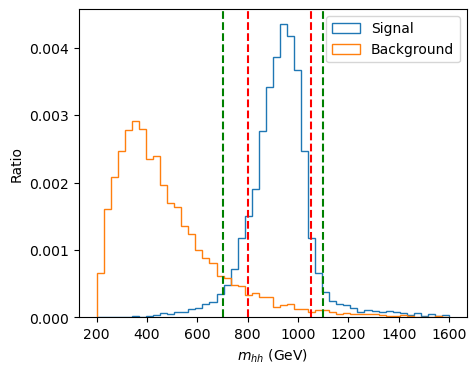

In [11]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

ax.hist(results_s['mhh'], range=(200,1600), bins=50, histtype='step', density=True, label='Signal')
ax.hist(results_b['mhh'], range=(200,1600), bins=50, histtype='step', density=True, label='Background')

# 指定要繪製垂直線的x座標
x_SR = [800,1050]
x_SB = [700,1100]
# 使用axvline函數繪製垂直線
ax.axvline(x=x_SR[0], color='r', linestyle='--')
ax.axvline(x=x_SR[1], color='r', linestyle='--')

ax.axvline(x=x_SB[0], color='g', linestyle='--')
ax.axvline(x=x_SB[1], color='g', linestyle='--')

ax.set_xlabel('$m_{hh}$ (GeV)')
ax.set_ylabel('Ratio')

ax.legend()
plt.savefig('./figures/mhh_distribution.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

In [12]:
def plot_mass_plane(mh, m10=120, m20=110, title='', save_path=None):
    # mh[0] for leading Higgs, mh[1] for sub-leading Higgs
    
    x_1 = mh[0]
    y_1 = mh[1]

    fig, ax = plt.subplots(1, 2, figsize =(10, 4))
                           
    delta = 1
    xrange = np.arange(1, 250, delta)
    yrange = np.arange(1, 250, delta)
    X, Y = np.meshgrid(xrange,yrange)
    # F is one side of the equation, G is the other
    F = ((X-m10)/(0.1*X))**2
    G = -((Y-m20)/(0.1*Y))**2 + 1.6**2
    ax[0].contour((F - G), [0], colors='y')

    # Creating plot
    hs = ax[0].hist2d(x_1, y_1, bins = [50, 50], range = [[50, 250], [50, 250]], cmin=1)
    ax[0].set_xlabel('$m_{h_1}$ (GeV)') 
    ax[0].set_ylabel('$m_{h_2}$ (GeV)') 
    ax[0].set_title(title)
    fig.colorbar(hs[3], ax=ax[0])


    ax[1].hist(x_1, bins=50, range=[0,200], histtype='step', label='Leading Higgs')
    ax[1].hist(y_1, bins=50, range=[0,200], histtype='step', label='Sub-leanding Higgs')
    ax[1].set_xlabel('Higgs mass (GeV)')
    ax[1].set_ylabel('Numbers')
    ax[1].legend(loc='best')
    ax[1].set_title(title)

    if save_path: 
        plt.savefig(save_path, dpi=300, facecolor='White', bbox_inches='tight')

    plt.show()

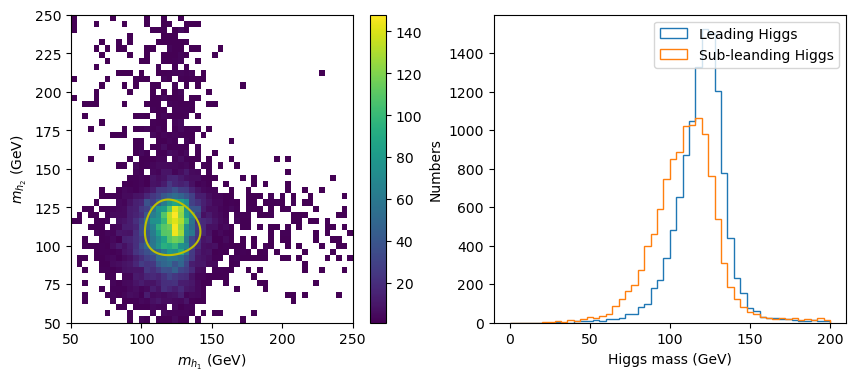

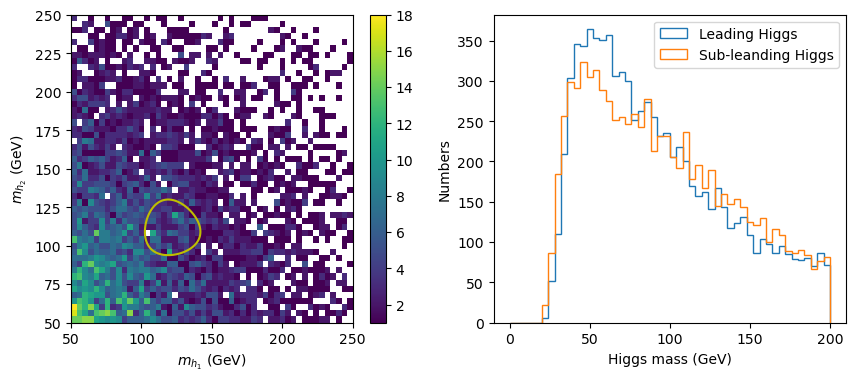

In [13]:
plot_mass_plane(results_s['mh'])
plot_mass_plane(results_b['mh'])

## Sensitivity

In [15]:
L = 139
ns = results_s['cutflow cross section']['Signal region'] * L
nb = results_b['cutflow cross section']['Signal region'] * L

print(f'S/B: {ns/nb:.2e}, S/sqrt(B): {ns/nb**0.5:.4f}')

S/B: 1.90e-04, S/sqrt(B): 0.0408


# Generate training sample

In [16]:
# Training sample consists of 1000 GeV sample and background sample

data_s = np.load('./Sample/DNN/min_dR_high_level_1000GeV_train.npy', allow_pickle=True).item()
data_b = np.load('./Sample/DNN/min_dR_high_level_train.npy', allow_pickle=True).item()

data_s = data_s['data'][data_s['label'] == 1]
data_b = data_b['data'][data_b['label'] == 0]

data_dict = {
    'data': np.vstack([data_s, data_b]),
    'label': np.array([1] * data_s.shape[0] + [0] * data_b.shape[0]),
}

np.save('./Sample/DNN/min_dR_1000GeV_train.npy', data_dict)

In [17]:
# Testing sample with true label

data_s = np.load('./Sample/DNN/min_dR_high_level_1000GeV_test.npy', allow_pickle=True).item()
data_b = np.load('./Sample/DNN/min_dR_high_level_test.npy', allow_pickle=True).item()

data_s = data_s['data'][data_s['label'] == 1]
data_b = data_b['data'][data_b['label'] == 0]

# balance the signal and background size
data_dict = {
    'data': np.vstack([data_s[:5000], data_b[:5000]]),
    'label': np.array([1] * 5000 + [0] * 5000),
}

np.save('./Sample/DNN/min_dR_1000GeV_test.npy', data_dict)

In [18]:
def create_mix_sample_from_numbers(file_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path, delete_col=(10,11,12,13,15)):
    # n_sig_1: number of signal events in mixing sample 1 (Signal region)
    # n_sig_2: number of signal events in mixing sample 2 (Sideband region)

    # signal and sideband range
    SR_range = [800, 1050]
    SB_range = [700, 1100] 

    data_dict = np.load(file_path, allow_pickle=True).item()

    sig_data = data_dict['data'][data_dict['label']==1]
    bkg_data = data_dict['data'][data_dict['label']==0]


    mhh_s = sig_data[:,15]

    SR_region = (mhh_s > SR_range[0]) & (mhh_s < SR_range[1])
    SB_region = ~SR_region & (mhh_s > SB_range[0]) & (mhh_s < SB_range[1])

    # exclude some features
    data_SR_S = np.delete(sig_data[SR_region], delete_col, axis=1)
    data_SB_S = np.delete(sig_data[SB_region], delete_col, axis=1)

    mhh_b = bkg_data[:,15]

    SR_region = (mhh_b > SR_range[0]) & (mhh_b < SR_range[1])
    SB_region = ~SR_region & (mhh_b > SB_range[0]) & (mhh_b < SB_range[1])

    # exclude some features
    data_SR_B = np.delete(bkg_data[SR_region], delete_col, axis=1)
    data_SB_B = np.delete(bkg_data[SB_region], delete_col, axis=1)

    if n_sig_1 > data_SR_S.shape[0] or n_bkg_1 > data_SR_B.shape[0] or n_sig_2 > data_SB_S.shape[0] or n_bkg_2 > data_SB_B.shape[0]:
        print('The number of input samples is not enough.')
        print(data_SR_B.shape[0], data_SB_B.shape[0])
        return

    sig_data_1, sig_data_2 = data_SR_S[:n_sig_1], data_SB_S[:n_sig_2]
    bkg_data_1, bkg_data_2 = data_SR_B[:n_bkg_1], data_SB_B[:n_bkg_2]
    
    data = np.vstack([sig_data_1, bkg_data_1, sig_data_2, bkg_data_2])
    label = np.array([1] * (n_sig_1+ n_bkg_1) + [0] * (n_sig_2 + n_bkg_2))
    
    # shuffle
    ind_list = list(range(len(label)))
    random.shuffle(ind_list)

    data = data[ind_list]
    label = label[ind_list]

    npy_dict = {'data': data, 'label': label}
    np.save(output_path, npy_dict)

In [19]:
file_path = './Sample/DNN/min_dR_1000GeV_train.npy'
n_sig_1, n_sig_2, n_bkg_1, n_bkg_2 = 5, 1, 25913, 24880
output_path = './Sample/DNN/CWoLa_hunting_with_signal.npy'
create_mix_sample_from_numbers(file_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path)

In [20]:
file_path = './Sample/DNN/min_dR_1000GeV_train.npy'
n_sig_1, n_sig_2, n_bkg_1, n_bkg_2 = 0, 0, 25913, 24880
output_path = './Sample/DNN/CWoLa_hunting_no_signal.npy'
create_mix_sample_from_numbers(file_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path)

# Training

In [ ]:
cmd = 'python train_CWoLa_hunting.py'
cmd = 'python train_CWoLa_hunting_no_sig.py'

# Results

In [21]:
def load_samples(path, delete_col=None):
    npy_dict = np.load(path, allow_pickle=True).item()
    
    X = npy_dict['data']
    if delete_col != None:
        X = np.delete(X, delete_col, axis=1)
    Y = np.eye(2)[npy_dict['label']]
    return X, Y

2023-11-09 23:07:43.598011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 23:07:44.422414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


 49/313 [===>..........................] - ETA: 0s - loss: 0.4442 - accuracy: 0.8903

2023-11-09 23:07:46.916137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 2s 3ms/step - loss: 0.4743 - accuracy: 0.8962
True label: Testing Loss = 0.474, Testing Accuracy = 0.896
313/313 [==============================] - 0s 1ms/step


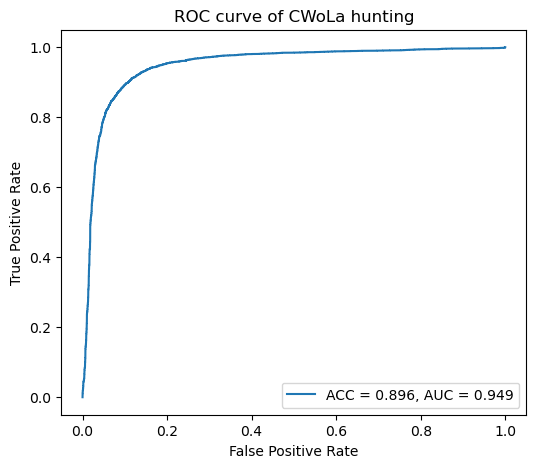

In [22]:
# Testing results on true label sample
d_col = [10,11,12,13,15]
true_label_path = f'./Sample/DNN/min_dR_1000GeV_test.npy'
X_test, y_test = load_samples(true_label_path, delete_col=d_col)

# Training results
loaded_model_name = f'./DNN/DNN_models/DNN_best_model_CWoLa_hunting_w_sig/'
loaded_model = tf.keras.models.load_model(loaded_model_name)
true_label_results = loaded_model.evaluate(x=X_test, y=y_test)

if true_label_results[1] < 0.5:
    y_test = y_test[:,[1,0]]
    true_label_results = loaded_model.evaluate(x=X_test, y=y_test)
print(f'True label: Testing Loss = {true_label_results[0]:.3}, Testing Accuracy = {true_label_results[1]:.3}')

# Compute AUC
labels = y_test
predictions = loaded_model.predict(X_test)

y_test = np.argmax(labels, axis=1)
y_prob = np.array(predictions)

i = 1
true_label_AUC = roc_auc_score(y_test==i,  y_prob[:,i])

fig, ax = plt.subplots(1, 1, figsize=(6,5))

fpr, tpr, thresholds = roc_curve(y_test==i, y_prob[:,i])
ax.plot(fpr, tpr, label = f'ACC = {true_label_results[1]:.3f}, AUC = {true_label_AUC:.3f}')

ax.set_title(f'ROC curve of CWoLa hunting')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# plt.savefig('./figures/ROC_CWoLa_hunting_1000GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

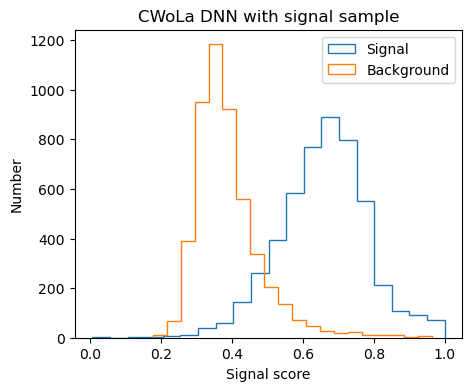

In [23]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

ax.hist(y_prob[:,1][y_test==1], bins=20, histtype='step', label='Signal')
ax.hist(y_prob[:,1][y_test==0], bins=20, histtype='step', label='Background')
ax.legend()
ax.set_xlabel('Signal score')
ax.set_ylabel('Number')
ax.set_title('CWoLa DNN with signal sample')
plt.savefig('./figures/DNN_w_sig_signal_score_distribution.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## Summary

In [24]:
file_name = './DNN/CWoLa_Hunting_training_results.csv'
df = pd.read_csv(file_name)

In [25]:
mu = df[df['Sample Type'] == 'With signal']['ACC-true'].mean()
sigma = df[df['Sample Type'] == 'With signal']['ACC-true'].std()
best = df[df['Sample Type'] == 'With signal']['ACC-true'].max()
print(f'ACC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')

mu = df[df['Sample Type'] == 'With signal']['AUC-true'].mean()
sigma = df[df['Sample Type'] == 'With signal']['AUC-true'].std()
best = df[df['Sample Type'] == 'With signal']['AUC-true'].max()
print(f'AUC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')

ACC: 0.868 +- 0.024, Best: 0.896
AUC: 0.925 +- 0.023, Best: 0.951


In [26]:
mu = df[df['Sample Type'] == 'No signal']['ACC-true'].mean()
sigma = df[df['Sample Type'] == 'No signal']['ACC-true'].std()
best = df[df['Sample Type'] == 'No signal']['ACC-true'].max()
print(f'ACC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')

mu = df[df['Sample Type'] == 'No signal']['AUC-true'].mean()
sigma = df[df['Sample Type'] == 'No signal']['AUC-true'].std()
best = df[df['Sample Type'] == 'No signal']['AUC-true'].max()
print(f'AUC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')

ACC: 0.850 +- 0.033, Best: 0.897
AUC: 0.909 +- 0.026, Best: 0.949


## Thresholds

In [27]:
def get_threshold_from_pass_rate(passing_rate, fpr, tpr, thresholds):
    n_th = ((fpr + tpr) < passing_rate * 2).sum()
    print(n_th)
    return thresholds[n_th]

In [28]:
th_010 = get_threshold_from_pass_rate(0.10, fpr, tpr, thresholds)
th_001 = get_threshold_from_pass_rate(0.01, fpr, tpr, thresholds)
th_0001 = get_threshold_from_pass_rate(0.001, fpr, tpr, thresholds)

print(th_010, th_001, th_0001)

92
8
2
0.7565069 0.9385723 0.9672062


# CWoLa selection

In [29]:
def diHiggs_selection_npy(file_path, tot_event, cross_section, th):
    # 輸入檔案為已配對的.npy檔
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選

    X, _ = load_samples(file_path)
    X_test, _ = load_samples(file_path, delete_col=[10,11,12,13,15])
    nevent = X.shape[0]
    Eta_PT_BTag_count = X.shape[0]

    # Model
    model_path = f'./DNN/DNN_models/DNN_last_model_CWoLa_hunting_w_sig/'
    loaded_model = tf.keras.models.load_model(model_path)

    predictions = loaded_model.predict(X_test)[:,1]

    mhh = X[:,15]
    mhh_DNN = X[:,15][predictions > th]

    SR_range = [800, 1050]
    SB_range = [700, 1100]

    predictions_SR = predictions[(SR_range[0] < mhh) & (mhh < SR_range[1])]

    SR_count = predictions_SR.shape[0]
    DNN_count = (predictions_SR > th).sum()
    
    
    # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
    cross_section_abs = cross_section * X.shape[0] / tot_event
    
    cutflow_count = {
        'nevent': tot_event,
        'Cross section': cross_section,
        'Four tag': Eta_PT_BTag_count,
        'Signal region': SR_count,
        'DNN selection': DNN_count,
        # 'Sideband region': SB_count,
    }
        
    cutflow_cross_section = {
        'nevent': nevent,
        'Cross section': cross_section,
        'Four tag': cross_section_abs,
        'Signal region': cross_section_abs * SR_count / nevent,
        'DNN selection': cross_section_abs * DNN_count / nevent,
        # 'Sideband region': cross_section_abs * SB_count / nevent,
    }
    
    results = {
        'cutflow count': cutflow_count,
        'cutflow cross section':cutflow_cross_section,
        'mhh': mhh,
        'DNN selected mhh': mhh_DNN,
    }
    
    return results

In [30]:
sample_path = f'../CPVDM/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_1000GeV/Events/h5_data/min_dR_high_level.npy'
run_path = '/home/r10222035/CPVDM/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_1000GeV/Events/run_01'
h5_path = '/home/r10222035/CPVDM/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_1000GeV/Events/h5_data/DiHiggs_4b_PT40.h5'

xection, tot_event = get_info(run_path)
results_s = diHiggs_selection_npy(sample_path,
                      tot_event,
                      xection,
                      th_010,
                      )

383/383 [==============================] - 1s 2ms/step


In [31]:
sample_path = f'./Sample/DNN/min_dR_high_level_bkg.npy'
run_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/MG5/resonant/pp4b_2525/Events/run_01'
h5_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/h5_data/resonant/pp4b_2525/1M_diHiggs_4b_PT40-01.h5'

xection, tot_event = get_info(run_path)
results_b = diHiggs_selection_npy(sample_path,
                      tot_event,
                      xection,
                      th_010,
                      )

300/300 [==============================] - 0s 1ms/step


In [32]:
print(results_s['cutflow count'])
print(results_b['cutflow count'])

{'nevent': 100000, 'Cross section': 0.66007, 'Four tag': 12234, 'Signal region': 9561, 'DNN selection': 1517}
{'nevent': 1000000, 'Cross section': 630389.756, 'Four tag': 9571, 'Signal region': 527, 'DNN selection': 25}


In [33]:
L = 139
ns = results_s['cutflow cross section']['Signal region'] * L
nb = results_b['cutflow cross section']['Signal region'] * L

print(f'S/B: {ns/nb:.2e}, S/sqrt(B): {ns/nb**0.5:.4f}')

ns = results_s['cutflow cross section']['DNN selection'] * L
nb = results_b['cutflow cross section']['DNN selection'] * L

print(f'S/B: {ns/nb:.2e}, S/sqrt(B): {ns/nb**0.5:.4f}')

S/B: 1.90e-04, S/sqrt(B): 0.0408
S/B: 6.35e-04, S/sqrt(B): 0.0297


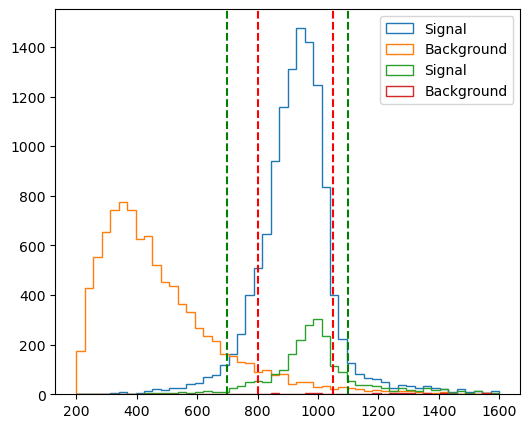

In [34]:
fig, ax = plt.subplots(1,1,figsize=(6, 5))

ax.hist(results_s['mhh'], range=(200,1600), bins=50, histtype='step', density=False, label='Signal')
ax.hist(results_b['mhh'], range=(200,1600), bins=50, histtype='step', density=False, label='Background')

ax.hist(results_s['DNN selected mhh'], range=(200,1600), bins=50, histtype='step', density=False, label='Signal')
ax.hist(results_b['DNN selected mhh'], range=(200,1600), bins=50, histtype='step', density=False, label='Background')

# 指定要繪製垂直線的x座標
x_SR = [800,1050]
x_SB = [700,1100]
# 使用axvline函數繪製垂直線
ax.axvline(x=x_SR[0], color='r', linestyle='--')
ax.axvline(x=x_SR[1], color='r', linestyle='--')

ax.axvline(x=x_SB[0], color='g', linestyle='--')
ax.axvline(x=x_SB[1], color='g', linestyle='--')

ax.legend()
plt.show()